# PCA 範例
* 以 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果

In [23]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import time

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [24]:
# 定義 PCA 與隨後的羅吉斯迴歸函數
# penalty 改為 L1, max_iter 改為 100
logistic = SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# 載入手寫數字辨識集
digits = datasets.load_digits()
X = digits.data
y = digits.target
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

X.shape: (1797, 64), y.shape: (1797,)


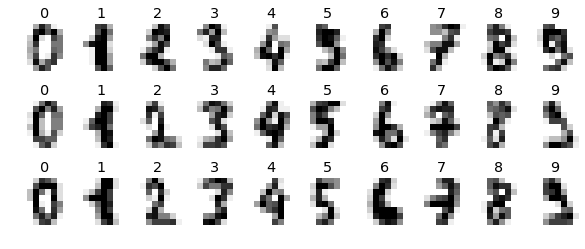

In [25]:
fig, axes = plt.subplots(3, 10, figsize=(10, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(8, 8), cmap=plt.cm.binary)
    ax.axis('off')
    ax.set_title(y[i])

In [26]:
### Define a Hyper Parameter Tuning function
def hyper_parameter_tuning(model, params, data, target):
    t0 = time.time()
    GSCV = GridSearchCV(pipe, param_grid, iid=False, cv=5, n_jobs=-1)
    GSCV.fit(data, target)
    t1 = time.time()
    print(f"Best accuracy: {GSCV.best_score_:.3f}")
    print(f"Best parameters: {GSCV.best_params_}")
    print(f"Avg. time to fit: {GSCV.cv_results_['mean_fit_time'].mean():.3f}")
    print(f"Avg. time to predict: {GSCV.cv_results_['mean_score_time'].mean():.3f}")
    print(f'Search time: {(t1 - t0):.4f}')
    return GSCV

In [27]:
### Define param grid
param_grid = {
    'pca__n_components': [4, 10, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}

In [28]:
# 執行 GridSearchCV 跑出最佳參數
search = hyper_parameter_tuning(pipe, param_grid, X, y)

Best accuracy: 0.913
Best parameters: {'logistic__alpha': 0.01, 'pca__n_components': 30}
Avg. time to fit: 0.729
Avg. time to predict: 0.002
Search time: 19.9417


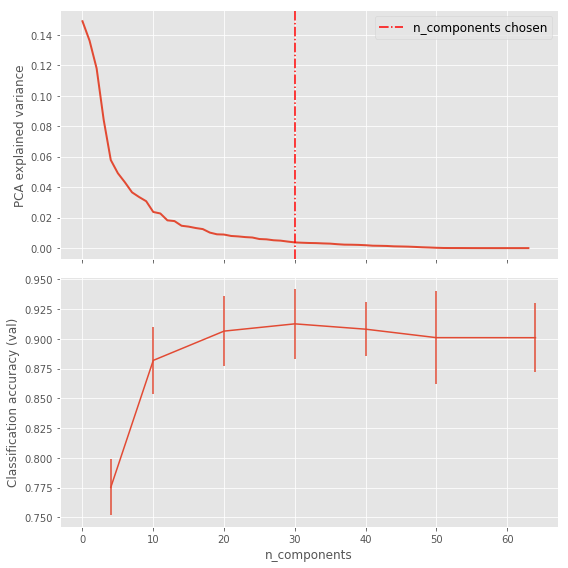

In [29]:
# 繪製不同 components 的 PCA explained variance ratio
pca.fit(X)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')
### axvline : Add a vertical line across the axes.
### .named_steps['pca']是從 pipeline提取 pca這個物件,在取出 n_components的結果
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle='-.', 
            color='r',label='n_components chosen')
ax0.legend(prop=dict(size=12))

#####################################################################################################

# 繪製 7 個不同採樣點的 accuracy
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
### groupby之後，以 nlargest查詢 mean_test_score最大的列值
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1,'mean_test_score'))
### plotting dataframe using matplotlib
### yerr ~ errorbar
best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.tight_layout()
plt.show()

In [30]:
### 參考他人 Code (Amy Chou):
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

df_acc = pd.DataFrame({}, columns=['n_components', 'accuracy', 'precision', 'recall', 'f1'])
df_acc['n_components'] = [1, 2, 4, 8, 16, 32, 64]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for n_components in [1, 2, 4, 8, 16, 32, 64]:
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    clf = SGDClassifier(alpha=0.01, loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='macro'))
    recall_scores.append(recall_score(y_test, y_pred, average='macro'))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    
df_acc['accuracy'] = accuracy_scores
df_acc['precision'] = precision_scores
df_acc['recall'] = recall_scores
df_acc['f1'] = f1_scores
df_acc

,n_components,accuracy,precision,recall,f1
0,1,0.308889,0.263775,0.306451,0.271031
1,2,0.491111,0.638982,0.487541,0.477253
2,4,0.771111,0.775813,0.771269,0.767502
3,8,0.877778,0.880059,0.876484,0.872323
4,16,0.908889,0.911277,0.908263,0.906195
5,32,0.937778,0.937371,0.937586,0.937048
6,64,0.937778,0.940455,0.937282,0.937207


Text(0, 0.5, 'accuracy score')

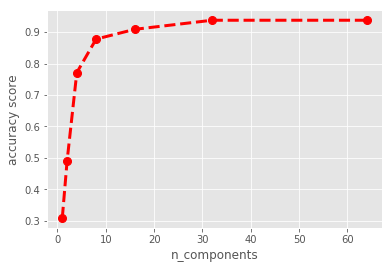

In [31]:
plt.plot(df_acc['n_components'] , df_acc['accuracy'],color='red', marker='o', linestyle='--',
         linewidth=3, markersize=8)
plt.xlabel('n_components')
plt.ylabel('accuracy score')